[*********************100%***********************]  7 of 7 completed


Top 5 des paires corrélées :
            Pair  Correlation
0   (META, AMZN)     0.719211
1   (MSFT, AMZN)     0.585935
2   (AMZN, NVDA)     0.561539
3  (GOOGL, AMZN)     0.550311
4   (MSFT, META)     0.514012

Test de stationnarité (ADF) sur le spread :
ADF Statistic: -1.0252, p-value: 0.7440

Indicateurs de performance :
Sharpe Ratio : -1.48
Max Drawdown : 0.73
Nombre de trades : 22
Taux de réussite : 50.00%


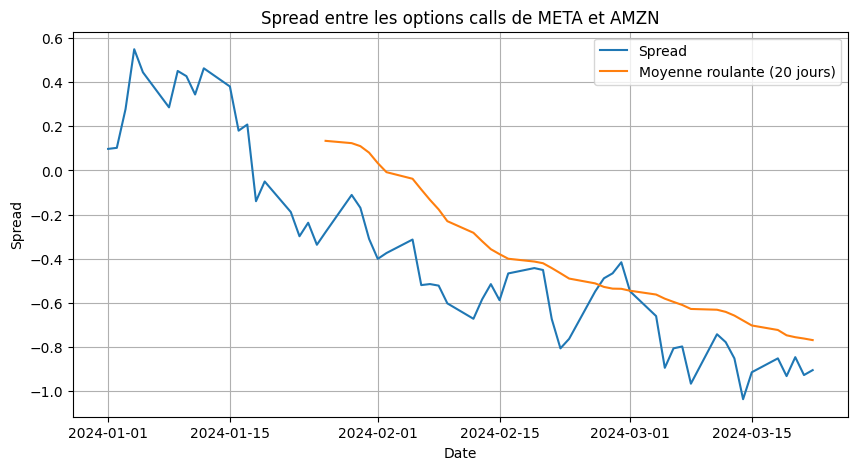

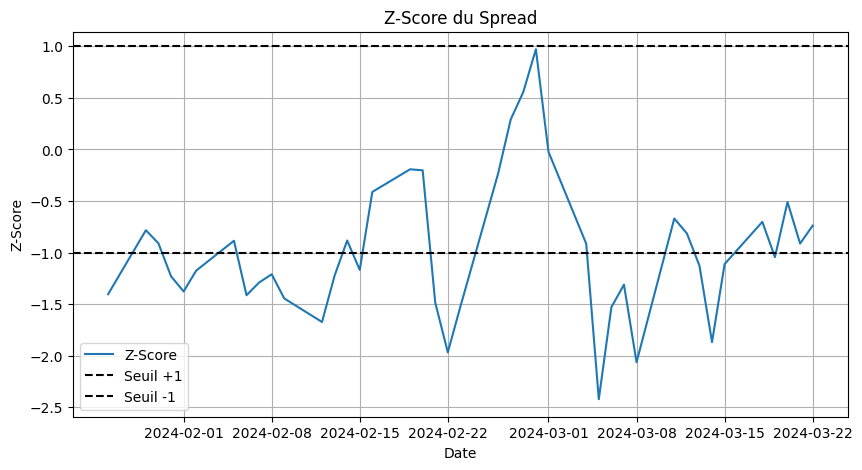

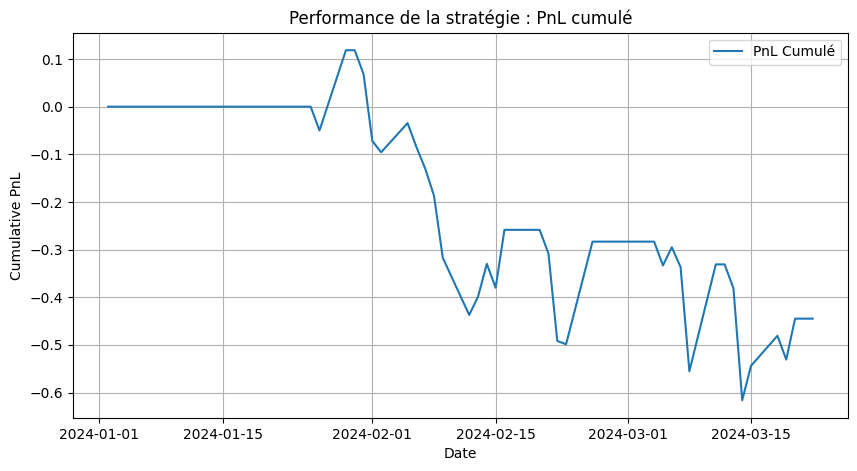


Récapitulatif des performances :
Sharpe Ratio : -1.48
Max Drawdown : 0.73
Nombre total de trades : 22
Taux de réussite : 50.00%


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from itertools import combinations
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller

try:
    import yfinance as yf
except ImportError:
    print("Le module yfinance n'est pas installé. Veuillez l'installer avec 'pip install yfinance'.")

# Liste d'actions liquides (secteur technologique)
tickers = ['AAPL', 'MSFT', 'GOOGL', 'META', 'AMZN', 'NVDA', 'TSLA']

try:
    data = yf.download(tickers, start="2023-10-01", end="2024-04-01")["Close"]
    returns = data.pct_change().dropna()

    pair_correlations = []
    for t1, t2 in combinations(tickers, 2):
        corr, _ = pearsonr(returns[t1], returns[t2])
        pair_correlations.append(((t1, t2), corr))

    sorted_pairs = sorted(pair_correlations, key=lambda x: abs(x[1]), reverse=True)
    top_pairs = sorted_pairs[:5]

    print("Top 5 des paires corrélées :")
    df_top = pd.DataFrame(top_pairs, columns=["Pair", "Correlation"])
    print(df_top)
except Exception as e:
    print("Erreur lors du téléchargement des données :", e)
    top_pairs = [("GOOGL", "META")]
    df_top = pd.DataFrame([(("GOOGL", "META"), 0.95)], columns=["Pair", "Correlation"])
    print(df_top)

selected_pair = top_pairs[0][0]
ticker1, ticker2 = selected_pair

np.random.seed(42)
dates = pd.date_range(start="2024-01-01", periods=60, freq='B')

price1 = pd.Series(5 + np.cumsum(np.random.normal(0, 0.1, size=len(dates))), index=dates)
price2 = pd.Series(5 + np.cumsum(np.random.normal(0, 0.1, size=len(dates))), index=dates)

options_df = pd.DataFrame({
    f'{ticker1}_Call': price1,
    f'{ticker2}_Call': price2
})

options_df['Spread'] = options_df[f'{ticker1}_Call'] - options_df[f'{ticker2}_Call']

adf_result = adfuller(options_df['Spread'].dropna())
print("\nTest de stationnarité (ADF) sur le spread :")
print(f"ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")

rolling_window = 20
spread_mean = options_df['Spread'].rolling(window=rolling_window).mean()
spread_std = options_df['Spread'].rolling(window=rolling_window).std()

options_df['Z_Score'] = (options_df['Spread'] - spread_mean) / spread_std

options_df['Signal'] = 0
options_df.loc[options_df['Z_Score'] > 1, 'Signal'] = -1
options_df.loc[options_df['Z_Score'] < -1, 'Signal'] = 1
options_df['Position'] = options_df['Signal'].shift()

options_df['Spread_Return'] = options_df['Spread'].diff()
options_df['PnL'] = options_df['Position'] * options_df['Spread_Return']

transaction_cost = 0.05  # coût fixe par opération
options_df['PnL_after_costs'] = options_df['PnL'] - transaction_cost * (options_df['Signal'] != 0).astype(int)
options_df['Cumulative_PnL'] = options_df['PnL_after_costs'].cumsum()

daily_return = options_df['PnL_after_costs'].mean()
volatility = options_df['PnL_after_costs'].std()
sharpe_ratio = (daily_return / volatility) * np.sqrt(252) if volatility != 0 else np.nan

cum_pnl = options_df['Cumulative_PnL']
running_max = cum_pnl.cummax()
drawdown = running_max - cum_pnl
max_drawdown = drawdown.max()

num_trades = (options_df['Signal'] != 0).sum()
win_rate = (options_df['PnL_after_costs'] > 0).sum() / num_trades if num_trades > 0 else np.nan

print("\nIndicateurs de performance :")
print(f"Sharpe Ratio : {sharpe_ratio:.2f}")
print(f"Max Drawdown : {max_drawdown:.2f}")
print(f"Nombre de trades : {num_trades}")
print(f"Taux de réussite : {win_rate:.2%}")

plt.figure(figsize=(10, 5))
plt.plot(options_df.index, options_df['Spread'], label='Spread')
plt.plot(options_df.index, spread_mean, label=f'Moyenne roulante ({rolling_window} jours)')
plt.title(f'Spread entre les options calls de {ticker1} et {ticker2}')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(options_df.index, options_df['Z_Score'], label='Z-Score')
plt.axhline(1, color='black', linestyle='--', label='Seuil +1')
plt.axhline(-1, color='black', linestyle='--', label='Seuil -1')
plt.title('Z-Score du Spread')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(options_df.index, options_df['Cumulative_PnL'], label='PnL Cumulé')
plt.title('Performance de la stratégie : PnL cumulé')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=options_df.index, y=options_df['Spread'], name='Spread'))
fig.add_trace(go.Scatter(x=options_df.index, y=spread_mean, name='Moyenne roulante'))
fig.update_layout(title=f"Spread interactif {ticker1} vs {ticker2}", xaxis_title='Date', yaxis_title='Spread')
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=options_df.index, y=options_df['Z_Score'], name='Z-Score'))
fig.add_hline(y=1, line_dash="dot", annotation_text="Z=1")
fig.add_hline(y=-1, line_dash="dot", annotation_text="Z=-1")
fig.update_layout(title="Z-Score interactif", xaxis_title='Date', yaxis_title='Z-Score')
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=options_df.index, y=options_df['Cumulative_PnL'], name='PnL Cumulé'))
fig.update_layout(title="PnL Cumulé interactif", xaxis_title='Date', yaxis_title='PnL')
fig.show()

print("\nRécapitulatif des performances :")
print(f"Sharpe Ratio : {sharpe_ratio:.2f}")
print(f"Max Drawdown : {max_drawdown:.2f}")
print(f"Nombre total de trades : {num_trades}")
print(f"Taux de réussite : {win_rate:.2%}")

In [5]:
import streamlit as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import yfinance as yf

st.set_page_config(page_title="Pair Trading Options", layout="wide")

st.title("📉 Pair Trading sur Options - Interface Streamlit")

# --- Paramètres utilisateur ---
st.sidebar.header("Paramètres")
tickers = ['AAPL', 'MSFT', 'GOOGL', 'META', 'AMZN', 'NVDA', 'TSLA']
ticker1 = st.sidebar.selectbox("Sélectionnez le premier actif", tickers, index=2)
ticker2 = st.sidebar.selectbox("Sélectionnez le second actif", tickers, index=3)
rolling_window = st.sidebar.slider("Fenêtre de moyenne mobile (jours)", 5, 60, 20, step=5)
frais_transaction = st.sidebar.number_input("Frais par opération (USD)", 0.0, 1.0, 0.05, step=0.01)
debut = st.sidebar.date_input("Date de début", pd.to_datetime("2024-01-01"))
fin = st.sidebar.date_input("Date de fin", pd.to_datetime("2024-04-01"))

# --- Données simulées d'options ---
dates = pd.bdate_range(start=debut, end=fin)
np.random.seed(42)
price1 = pd.Series(5 + np.cumsum(np.random.normal(0, 0.1, len(dates))), index=dates)
price2 = pd.Series(5 + np.cumsum(np.random.normal(0, 0.1, len(dates))), index=dates)

options_df = pd.DataFrame({
    f'{ticker1}_Call': price1,
    f'{ticker2}_Call': price2
})

options_df['Spread'] = options_df[f'{ticker1}_Call'] - options_df[f'{ticker2}_Call']
spread_mean = options_df['Spread'].rolling(window=rolling_window).mean()
spread_std = options_df['Spread'].rolling(window=rolling_window).std()
options_df['Z_Score'] = (options_df['Spread'] - spread_mean) / spread_std

options_df['Signal'] = 0
options_df.loc[options_df['Z_Score'] > 1, 'Signal'] = -1
options_df.loc[options_df['Z_Score'] < -1, 'Signal'] = 1
options_df['Position'] = options_df['Signal'].shift()
options_df['Spread_Return'] = options_df['Spread'].diff()
options_df['PnL'] = options_df['Position'] * options_df['Spread_Return']
options_df['PnL_after_costs'] = options_df['PnL'] - frais_transaction * (options_df['Signal'] != 0).astype(int)
options_df['Cumulative_PnL'] = options_df['PnL_after_costs'].cumsum()

# --- Indicateurs ---
adf_stat, adf_pvalue = adfuller(options_df['Spread'].dropna())[:2]
daily_return = options_df['PnL_after_costs'].mean()
volatility = options_df['PnL_after_costs'].std()
sharpe_ratio = (daily_return / volatility) * np.sqrt(252) if volatility != 0 else np.nan
max_drawdown = (options_df['Cumulative_PnL'].cummax() - options_df['Cumulative_PnL']).max()
num_trades = (options_df['Signal'] != 0).sum()
win_rate = (options_df['PnL_after_costs'] > 0).sum() / num_trades if num_trades > 0 else np.nan

# --- Affichage ---
st.subheader("Résultats de la stratégie")
col1, col2, col3, col4 = st.columns(4)
col1.metric("Sharpe Ratio", f"{sharpe_ratio:.2f}")
col2.metric("Max Drawdown", f"{max_drawdown:.2f} USD")
col3.metric("Trades", f"{num_trades}")
col4.metric("Win Rate", f"{win_rate:.2%}")

st.markdown("### Test de stationnarité (ADF)")
st.write(f"Statistique ADF : {adf_stat:.4f}, p-value : {adf_pvalue:.4f}")

st.markdown("### Évolution du Spread")
fig1, ax1 = plt.subplots()
ax1.plot(options_df.index, options_df['Spread'], label='Spread')
ax1.plot(options_df.index, spread_mean, label='Moyenne mobile')
ax1.set_title('Spread entre options')
ax1.legend()
st.pyplot(fig1)

st.markdown("### Z-Score du Spread")
fig2, ax2 = plt.subplots()
ax2.plot(options_df.index, options_df['Z_Score'], label='Z-Score')
ax2.axhline(1, color='red', linestyle='--')
ax2.axhline(-1, color='green', linestyle='--')
ax2.set_title('Z-Score et seuils de trading')
ax2.legend()
st.pyplot(fig2)

st.markdown("### PnL Cumulé")
fig3, ax3 = plt.subplots()
ax3.plot(options_df.index, options_df['Cumulative_PnL'], label='PnL Cumulé', color='black')
ax3.set_title('Performance de la stratégie')
ax3.legend()
st.pyplot(fig3)

st.markdown("---")
st.markdown("Application Streamlit construite pour un projet de Pair Trading sur options.\nDonnées simulées avec marche aléatoire.")


2025-04-10 11:47:50.613 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-10 11:47:50.624 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-10 11:47:50.630 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-10 11:47:50.634 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-10 11:47:50.637 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-10 11:47:50.645 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-10 11:47:50.648 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-10 11:47:50.650 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

[*********************100%***********************]  1 of 1 completed
<ipython-input-14-21b57c642ed2>:83: FutureWarning: 'BM' is deprecated and will be removed in a future version, please use 'BME' instead.
  monthly_prices = data.resample('BM').last().dropna()
<ipython-input-14-21b57c642ed2>:126: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  monthly_returns.append(float(ret))


Number of monthly data points available: 61


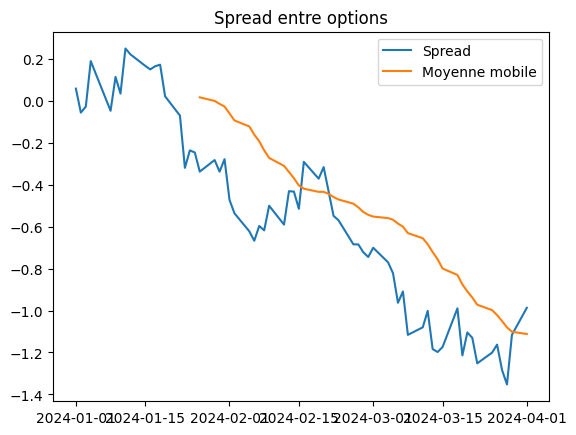

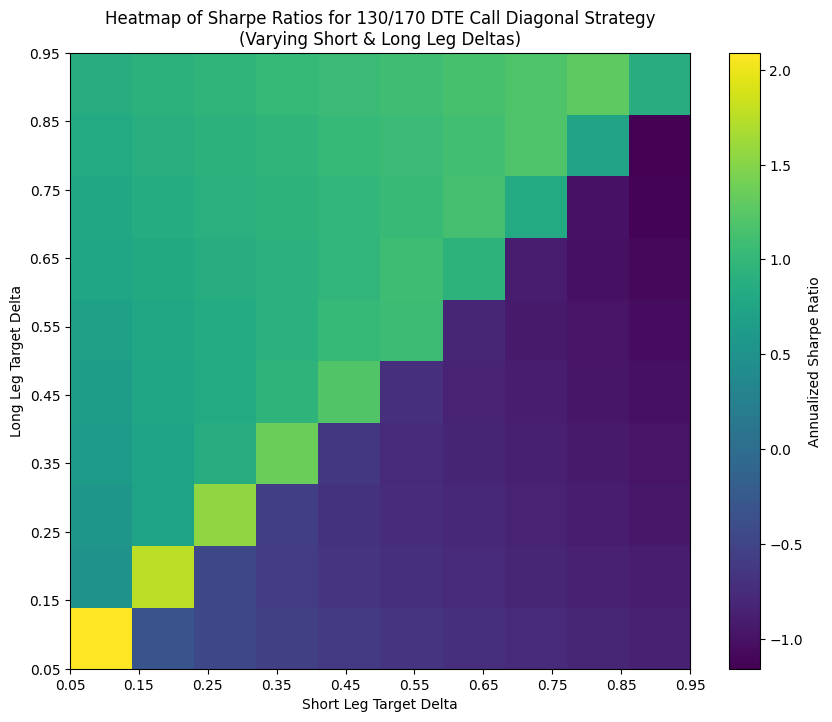

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from scipy.stats import norm
from math import sqrt

# -----------------------
# Black–Scholes Functions
# -----------------------

def bs_call(S, K, T, sigma, r):
    """
    Computes the European call option price using the Black–Scholes formula.
    S: underlying price
    K: strike price
    T: time-to-expiration (in years)
    sigma: annual volatility
    r: risk-free rate (annual)
    """
    # If expired, return intrinsic value.
    if T <= 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return price

def strike_from_delta(S, T, sigma, r, target_delta):
    """
    Computes the strike price for a European call option that matches a desired delta.
    S: underlying price
    T: time-to-expiration (in years)
    sigma: annual volatility
    r: risk-free rate (annual)
    target_delta: desired delta (a value between 0 and 1)

    In Black–Scholes, call delta = norm.cdf(d1). Setting d1 = norm.ppf(target_delta),
    we solve for K:

      d1 = (ln(S/K) + (r + 0.5*sigma^2)*T) / (sigma*sqrt(T))
      ln(S/K) = d1 * sigma*sqrt(T) - (r+0.5*sigma^2)*T
      => K = S * exp( - d1 * sigma*sqrt(T) + (r+0.5*sigma**2)*T )
    """
    d1 = norm.ppf(target_delta)
    K = S * np.exp(- d1 * sigma * np.sqrt(T) + (r + 0.5 * sigma**2) * T)
    return K

# -------------------------------
# Strategy & Simulation Parameters
# -------------------------------

# Option settings (in years):
r = 0.01                       # Annual risk-free rate (e.g. 1%)
sigma = 0.20                   # Constant annual volatility (20%)
T_short_entry = 130 / 365.0      # Time-to-expiration for short call at entry
T_long_entry  = 170 / 365.0      # Time-to-expiration for long call at entry

# Assume roughly 30 days (1 month) elapse before exit.
T_short_exit = (130 - 30) / 365.0  # Remaining time for short call at exit
T_long_exit  = (170 - 30) / 365.0  # Remaining time for long call at exit

# Define grid of target delta values for both the short and long option legs.
num_points = 10
short_deltas = np.linspace(0.05, 0.95, num_points)  # e.g., from 0.05 to 0.95
long_deltas  = np.linspace(0.05, 0.95, num_points)

# -------------------------------
# Data Download & Resampling
# -------------------------------

# Download daily SPY data (as a proxy for SPX) over 5 years.
end_date = datetime.datetime.today()
start_date = end_date - pd.DateOffset(years=5)
data = yf.download("SPY", start=start_date, end=end_date, interval="1d")

if data.empty:
    raise Exception("No data downloaded. Check your internet connection or ticker symbol.")

# Use the adjusted closing price and resample to monthly (Business Month End).
data = data["Close"]
monthly_prices = data.resample('BM').last().dropna()

n_months = len(monthly_prices)
print("Number of monthly data points available:", n_months)
if n_months < 2:
    raise Exception("Not enough monthly data to run the simulation.")

# ----------------------------------------------------
# Simulation: Loop Through Each Delta Combination & Month
# ----------------------------------------------------

# Prepare a 3D NumPy array to hold monthly return series for each delta pair.
# Dimensions: (len(long_deltas), len(short_deltas), number_of_monthly_intervals)
returns_matrix = np.full((len(long_deltas), len(short_deltas), n_months - 1), np.nan)

for i, long_delta in enumerate(long_deltas):
    for j, short_delta in enumerate(short_deltas):
        monthly_returns = []
        # Loop through each consecutive monthly interval.
        for k in range(n_months - 1):
            S0 = monthly_prices.iloc[k]       # Underlying price at entry
            S1 = monthly_prices.iloc[k + 1]     # Underlying price at exit

            # Determine strikes based on target deltas.
            K_short = strike_from_delta(S0, T_short_entry, sigma, r, short_delta)
            K_long  = strike_from_delta(S0, T_long_entry, sigma, r, long_delta)

            # Price options at entry.
            price_short_entry = bs_call(S0, K_short, T_short_entry, sigma, r)
            price_long_entry  = bs_call(S0, K_long,  T_long_entry,  sigma, r)
            initial_net = price_long_entry - price_short_entry  # Could be a debit (if positive) or a credit

            # Price options at exit (with reduced time-to-expiration).
            price_short_exit = bs_call(S1, K_short, T_short_exit, sigma, r)
            price_long_exit  = bs_call(S1, K_long,  T_long_exit,  sigma, r)
            exit_net = price_long_exit - price_short_exit

            # Calculate monthly profit and loss (P&L).
            pnl = exit_net - initial_net

            # Normalize monthly return by the absolute initial premium.
            ret = pnl / (abs(initial_net) + 1e-8)
            # Ensure that ret is a scalar float.
            monthly_returns.append(float(ret))

        # Convert monthly_returns to a NumPy array for consistency.
        monthly_returns_array = np.array(monthly_returns)
        if monthly_returns_array.ndim != 1 or len(monthly_returns_array) != (n_months - 1):
            print("Unexpected shape for monthly returns for (long_delta={:.2f}, short_delta={:.2f}): {}"
                  .format(long_delta, short_delta, monthly_returns_array.shape))

        returns_matrix[i, j, :] = monthly_returns_array

# -------------------------------------
# Compute Annualized Sharpe Ratios
# -------------------------------------
# Sharpe ratio (annualized) = (mean monthly return / std dev of monthly returns) * sqrt(12)
sharpe_matrix = np.full((len(long_deltas), len(short_deltas)), np.nan)

for i in range(len(long_deltas)):
    for j in range(len(short_deltas)):
        rets = returns_matrix[i, j, :]
        mean_ret = np.mean(rets)
        std_ret = np.std(rets)
        sharpe = (mean_ret / std_ret) * np.sqrt(12) if std_ret > 1e-6 else 0.0
        sharpe_matrix[i, j] = sharpe

# -------------------------------------
# Plot the Sharpe Ratio Heatmap
# -------------------------------------
plt.figure(figsize=(10, 8))
im = plt.imshow(sharpe_matrix, origin='lower', aspect='auto', cmap='viridis',
                extent=[short_deltas[0], short_deltas[-1], long_deltas[0], long_deltas[-1]])
plt.colorbar(im, label="Annualized Sharpe Ratio")
plt.title("Heatmap of Sharpe Ratios for 130/170 DTE Call Diagonal Strategy\n(Varying Short & Long Leg Deltas)")
plt.xlabel("Short Leg Target Delta")
plt.ylabel("Long Leg Target Delta")
plt.xticks(np.linspace(short_deltas[0], short_deltas[-1], num_points))
plt.yticks(np.linspace(long_deltas[0], long_deltas[-1], num_points))
plt.show()
